In [1]:
%pip install gridstatus pandas isodata requests seaborn

Note: you may need to restart the kernel to use updated packages.


Set Up Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os
import numpy as np 

load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
if not DATABASE_URL:
        raise ValueError("DATABASE_URL not found in .env")
engine = create_engine(DATABASE_URL)

Load Data

In [3]:
eia_data = "SELECT * FROM eia_data WHERE subba = 'ZONJ' "
weather_data = "SELECT * FROM weather_data WHERE city = 'NYC' "

eia_df = pd.read_sql(eia_data,engine)
weather_df = pd.read_sql(weather_data,engine)

df = pd.merge(eia_df, weather_df, on="period", how="inner" )
df = df.dropna()

In [4]:
target = "value"
features = ["temp", "humidity", "wind", "cloud", "precip"]

X = df[features]
y = df[target]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

In [6]:
# Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
r2_lr

0.20524668152982195

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators= 100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
r2_rf

0.7256811195168916

In [8]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(64,32), max_iter = 2000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
r2_mlp = r2_score(y_test, y_pred_mlp)
r2_mlp

0.5445507873174855

In [9]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=150, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_xgb

0.5782979159505793

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(32, input_dim = X_train.shape[1], activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=0)

y_pred_nn = model.predict(X_test_scaled).flatten()
r2_nn = r2_score(y_test, y_pred_nn)
r2_nn


/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime ve

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 243us/step


0.5458907314316802

In [11]:
# Fine tune Random Forest Using GridSearch
# Create the Paramteres
n_estimators = [int(x) for x in np.linspace(start=10, stop=200, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [None, 2, 5, 10, 20]
min_samples_split = [2,5, 10]
min_samples_leaf= [1,2, 4]
bootstrap = [True, False]

In [12]:
# Create the parm grid
param_grid = { 'n_estimators': n_estimators,
                'max_features' : max_features,
                'max_depth' : max_depth,
                'min_samples_split' : min_samples_split,
                'min_samples_leaf': min_samples_leaf, 
                'bootstrap' : bootstrap
}
param_grid

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200],
 'max_features': ['auto', 'sqrt', 'log2'],
 'max_depth': [None, 2, 5, 10, 20],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [13]:
# Random Forest with CSV
from sklearn.model_selection import GridSearchCV
rf_Grid = GridSearchCV(estimator = rf, param_grid= param_grid, cv = 3, verbose =2, n_jobs=1)
rf_Grid.fit(X_train, y_train)
rf_Grid.best_params_

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=31; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators

/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
2700 fits failed out of a total of 8100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2700 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jairespinoza/Desktop/Coding_Folder/Node_Fun/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1356, in wrapper
    estimator._validate_params()
 

{'bootstrap': False,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# best param returned
rfcv = RandomForestRegressor(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

rfcv.fit(X_train, y_train)
y_pred_rfcv = rfcv.predict(X_test)
r2_rfcv = r2_score(y_test, y_pred_rfcv)
r2_rfcv

0.7587805159805275

In [17]:
# Micro Tune 
micro_param_grid = {
    'bootstrap': [False], 
    'max_depth': [None, 15, 20], 
    'max_features': ['sqrt', 0.5],  # try proportion
    'min_samples_leaf': [1, 2],  # add slight regularization
    'min_samples_split': [2, 3, 4],  # slightly higher split
    'n_estimators': [180, 200, 220, 250]
}

rf_micro = GridSearchCV(estimator = rf, param_grid= micro_param_grid, cv = 3, verbose =2, n_jobs=1)
rf_micro.fit(X_train, y_train)
y_pred_rf_micro = rf_micro.best_estimator_.predict(X_test)
r2_rfMicro = r2_score(y_test, y_pred_rf_micro)
r2_rfMicro


Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=  11.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=  11.3s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=180; total time=  11.0s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.7s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=  12.9s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n

0.757852983380007

R^2: 0.7587805159805275
Var_y Total: 1345860.4102284885
Var(y-hat) Total 324647.6514889438


<function matplotlib.pyplot.show(close=None, block=None)>

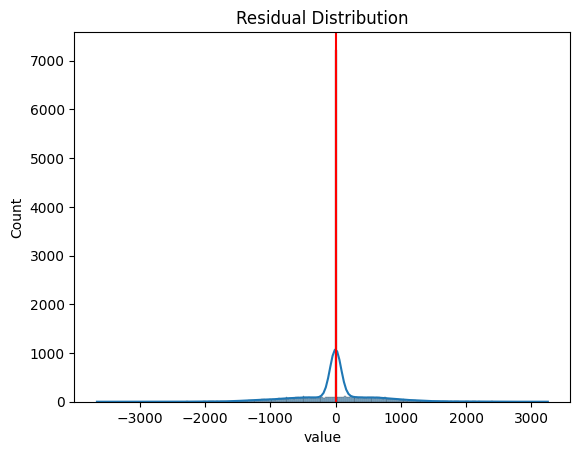

In [ ]:
# Plot Residual Distribution
residuals = y_test - y_pred_rfcv; 
var_y = np.var(y_test, ddof=1)
var_r = np.var(residuals, ddof=1)

print("R^2:", r2_rfcv)
print("Var_y Total:", var_y)
print("Var(y-hat) Total", var_r)

sns.histplot(residuals, kde=True)
plt.axvline(0, color = 'red')
plt.title("Residual Distribution")
plt.show

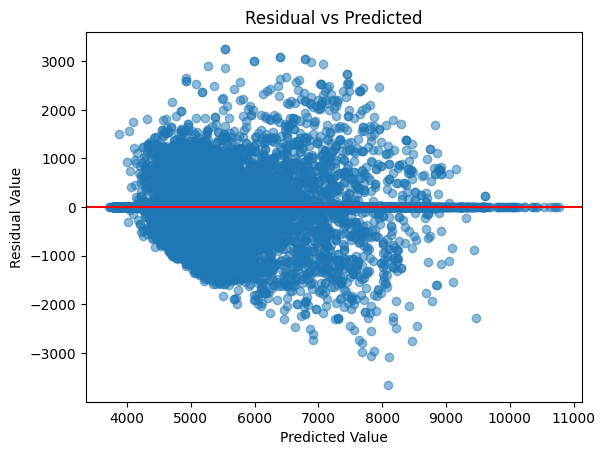

In [ ]:
# Resiudal Patterns Overesitmation vs Underestimation
plt.scatter(y_pred_rfcv, residuals, alpha=0.5)
plt.axhline(0, color = 'red')
plt.xlabel("Predicted Value")
plt.ylabel("Residual Value")
plt.title("Residual vs Predicted")
plt.show()

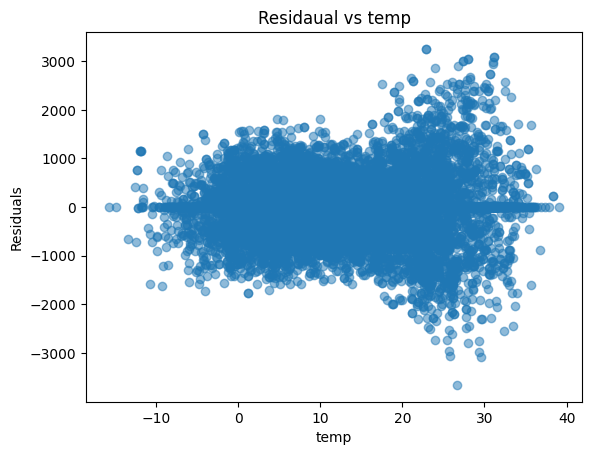

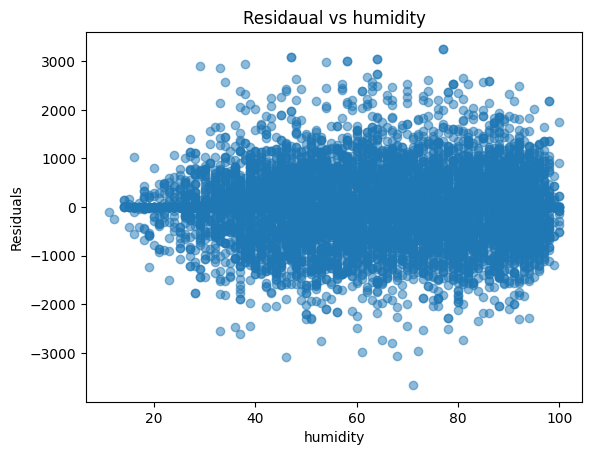

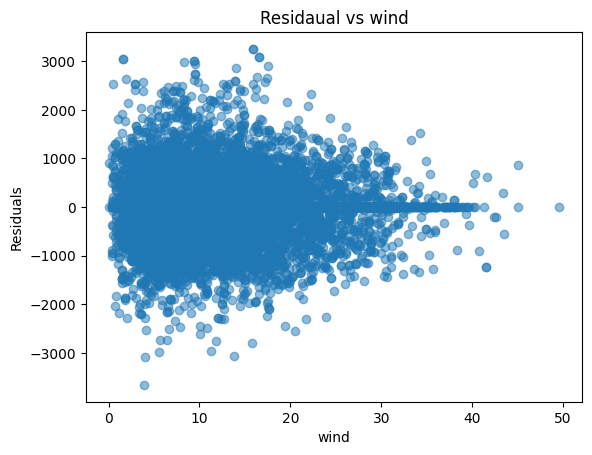

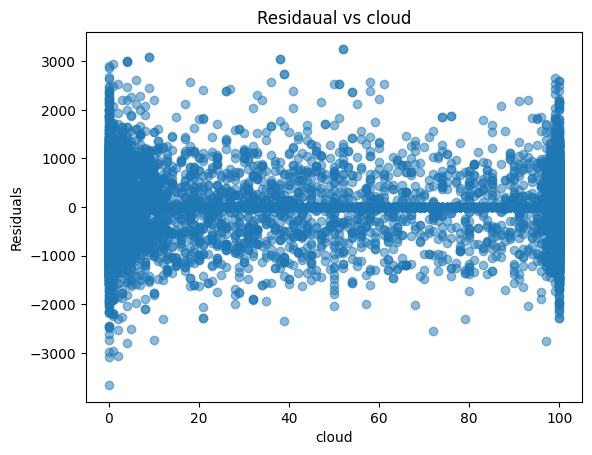

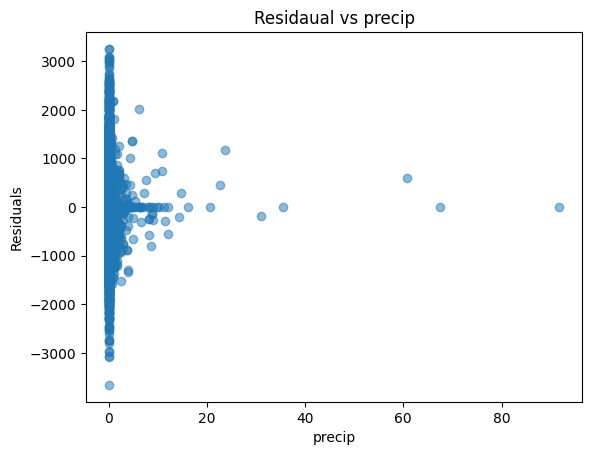

In [33]:
for col in X_test.columns:
    plt.scatter(X_test[col], residuals, alpha =0.5 )
    plt.xlabel(col)
    plt.ylabel("Residuals")
    plt.title(f"Residaual vs {col}")
    plt.show()

In [ ]:
# Handle missing cloud values
X_train["cloud"] = X_train["cloud"].fillna(0)  

# Make bins that include everything
cloud_bins = pd.cut(X_train["cloud"], bins=[0.1, 20, 80, 100], labels=["low", "mid", "high"], include_lowest=True)

# Variance per bin
var_per_bin = residuals.groupby(cloud_bins).var()

# Safely map weights (handle NaNs)
weights = cloud_bins.map(lambda b: 1 / var_per_bin.loc[b] if pd.notna(b) else 1)

rfcv_weighted = RandomForestRegressor(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

# Train weighted RF
rfcv_weighted.fit(X_train, y_train, sample_weight=weights)

# Evaluate
y_pred_weighted = rfcv_weighted.predict(X_test)
r2_weighted = r2_score(y_test, y_pred_weighted)
print("R Sqaure:", r2_weighted)


/var/folders/n3/z_r7fhkd0hd475xfhz69wl1c0000gn/T/ipykernel_2469/741548076.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  var_per_bin = residuals.groupby(cloud_bins).var()


R Sqaure: 0.7588495363272547


In [ ]:
import joblib

joblib.dump(rfcv_weighted, "rfGS_Weighted.pkl")

['rfGS_Weighted.pkl']

In [46]:
X_features = X_test.copy()
residuals = y_test - rfcv_weighted.predict(X_test)
X_with_resid = X_test.copy()
X_with_resid["residual"] = residuals

In [ ]:
from sklearn.ensemble import IsolationForest

iso_f = IsolationForest(contamination=0.01, random_state=42)
iso_f.fit(X_with_resid)
label = iso_f.predict(X_with_resid)

# 1 is normal -1 means anomaly
anomaly_index = np.where(label == -1)[0]

print("Anomalies Found At Row", anomaly_index)

Anomalies Found [  541   761   924  1019  1104  1152  1223  1252  1311  1350  1373  1388
  1538  1613  1631  1678  1808  1878  2143  2177  2451  2553  2647  2655
  2669  2858  2861  2963  3018  3028  3167  3319  3503  3516  3521  3572
  3673  3728  3767  3835  3972  3995  4184  4277  4364  4430  4576  4590
  4635  4658  4726  4796  4812  4883  4996  5022  5055  5069  5271  5312
  5475  5664  5754  5847  6036  6038  6236  6248  6250  6371  6633  6728
  6799  6802  6859  6999  7056  7074  7188  7190  7235  7266  7422  7519
  7584  7600  7638  7647  7715  7861  7944  8160  8253  8311  8324  8423
  8514  8614  8775  9031  9169  9319  9491  9617  9629  9788  9883 10103
 10214 10260 10262 10350 10545 10677 10682 10965 11251 11259 11396 11635
 11673 11699 11781 11807 11879 12079 12160 12165 12172 12564 12590 12627
 12786 12968 12979 13131 13165 13230 13488 13809 13959 13961]


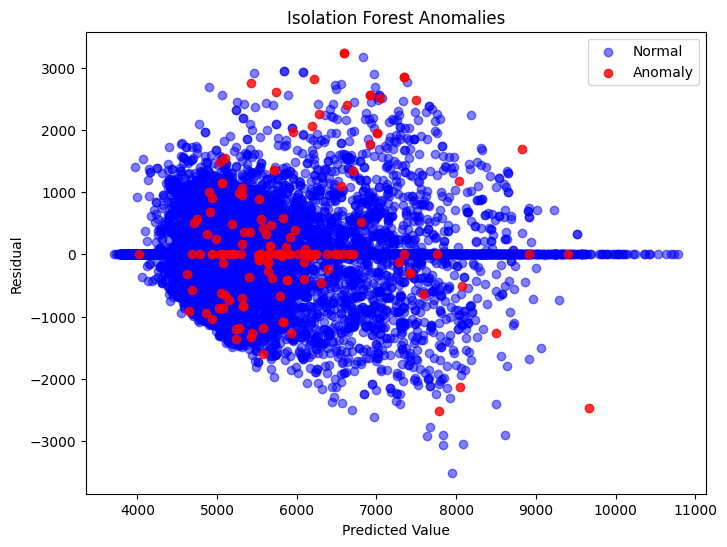

In [52]:
y_pred = rfcv_weighted.predict(X_test)

# Mask for anomalies
anomaly_mask = np.isin(np.arange(len(X_with_resid)), anomaly_index)

# Plot normal points
plt.figure(figsize=(8, 6))
plt.scatter(
    y_pred[~anomaly_mask],
    residuals[~anomaly_mask],
    alpha=0.5,
    color="blue",
    label="Normal"
)

# Plot anomalies
plt.scatter(
    y_pred[anomaly_mask],
    residuals[anomaly_mask],
    alpha=0.8,
    color="red",
    label="Anomaly"
)

plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.title("Isolation Forest Anomalies")
plt.legend()

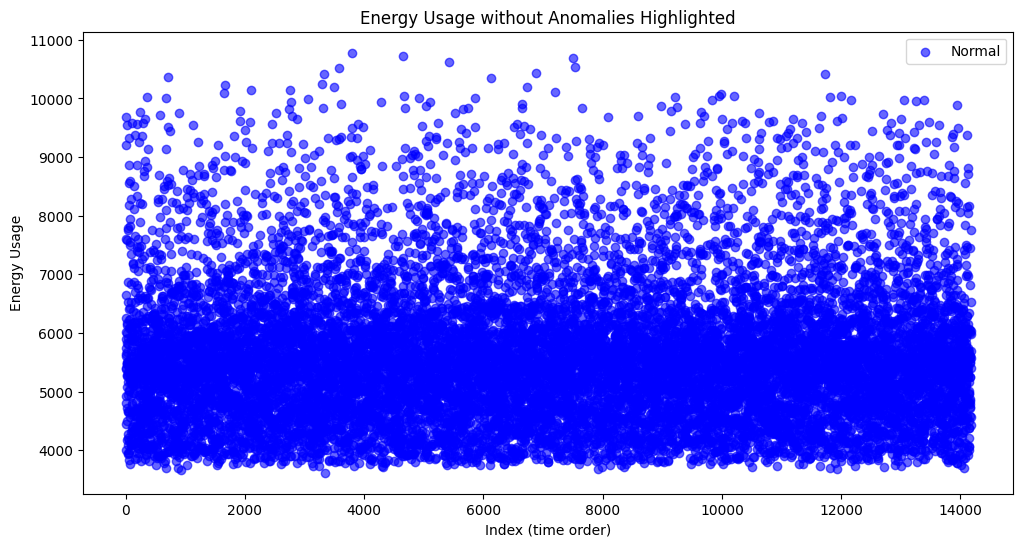

In [ ]:
plt.figure(figsize=(12,6))
plt.scatter(range(len(y_test)), y_test, 
            color='blue', label='Normal', alpha=0.6)

plt.xlabel("Index (time order)")
plt.ylabel("Energy Usage")
plt.title("Energy Usage without Anomalies Highlighted")
plt.legend()
plt.show()

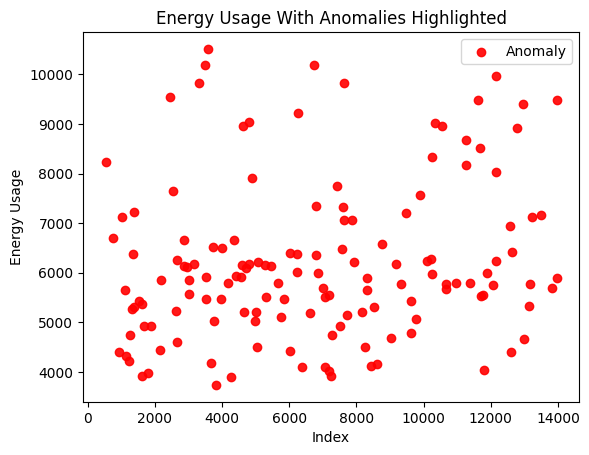

In [57]:
#  anomaly mask
anomaly_mask = (label == -1)

plt.scatter(np.where(anomaly_mask)[0], y_test[anomaly_mask], 
            color='red', label='Anomaly', alpha=0.9)

plt.xlabel("Index")
plt.ylabel("Energy Usage")
plt.title("Energy Usage With Anomalies Highlighted")
plt.legend()
plt.show()

In [56]:
joblib.dump(iso_f, "ano_detection_iso_f.pkl")

['ano_detection_iso_f.pkl']